In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer

/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from transformers import BertForTokenClassification, BertTokenizer,  BertForMaskedLM, Trainer, TrainingArguments
from datasets import load_dataset
from transformers import DataCollatorForTokenClassification
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import os
from transformers import BertTokenizerFast
import evaluate
import pandas as pd
import random
from datasets import DatasetDict
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
from datasets import load_dataset

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
dataset = load_dataset("jnlpba", trust_remote_code = True)

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 18546
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 3856
    })
})

In [7]:
# Define a sampling function
def sample_dataset(data, ratio):
    sample_size = int(len(data) * ratio)
    return data.select(random.sample(range(len(data)), sample_size))

# Set the ratio
ratio = 0.05

# Sample each subset
train_sampled = sample_dataset(dataset['train'], ratio)
validation_sampled = sample_dataset(dataset['validation'], ratio)

# Check the sizes
print(f"Sampled train size: {len(train_sampled)}")
print(f"Sampled validation size: {len(validation_sampled)}")


dataset = DatasetDict({
    "train": train_sampled,
    "validation": validation_sampled
})


Sampled train size: 927
Sampled validation size: 192


In [8]:
dataset['train'][0]['tokens']

['We',
 'have',
 'carried',
 'out',
 'experiments',
 'to',
 'define',
 'the',
 'nature',
 'of',
 'the',
 'higher',
 'affinity',
 'CVZ',
 'binding',
 'site',
 '.']

In [9]:
dataset['train'][0]['ner_tags']

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 10, 10, 0]

In [10]:
dataset['train'][0]['id']

'16921'

In [11]:
label_list = dataset["train"].features[f"ner_tags"].feature.names
num_labels = len(label_list)
label_list



['O',
 'B-DNA',
 'I-DNA',
 'B-RNA',
 'I-RNA',
 'B-cell_line',
 'I-cell_line',
 'B-cell_type',
 'I-cell_type',
 'B-protein',
 'I-protein']

In [12]:
sample_data = dataset["train"].select(range(10)) 

df = pd.DataFrame({
    "tokens": [" ".join(example["tokens"]) for example in sample_data],
    "ner_tags": [example["ner_tags"] for example in sample_data]
})

df

,tokens,ner_tags
0,We have carried out experiments to define the ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 1..."
1,The disappearance of NF kappa B from the nucle...,"[0, 0, 0, 9, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
2,The M-CSF gene was expressed in 6 cases and th...,"[0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, ..."
3,"Our results suggest that Syk , in contrast to ...","[0, 0, 0, 0, 9, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, ..."
4,Single point estimation of glucocorticoid rece...,"[0, 0, 0, 0, 9, 10, 0, 7, 0, 0, 0, 0, 0, 0, 0,..."
5,AML1 may play a role in growth and differentia...,"[9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 8, 8, ..."
6,Inducible expression and phosphorylation of co...,"[0, 0, 0, 0, 0, 9, 10, 0, 7, 8, 0, 0, 0, 0]"
7,"Importantly , two previously characterized mut...","[0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 9, 0, 9, 0, 0, ..."
8,Since the co-expression with a dominant negati...,"[0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, ..."
9,"Interleukin-5 ( IL-5 ) , which is produced by ...","[9, 0, 9, 0, 0, 0, 0, 0, 0, 7, 8, 8, 8, 8, 8, ..."


B- indicates the beginning of an entity.
I- indicates a token is contained inside the same entity (for example, the State token is a part of an entity like Empire State Building).
0 indicates the token doesn’t correspond to any entity.

In [13]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

In [14]:

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding='max_length',
        max_length=128
    )
    labels = []
    for i, label in enumerate(examples['ner_tags']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs





In [15]:

tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/927 [00:00<?, ? examples/s]

Map: 100%|██████████| 192/192 [00:00<00:00, 10582.35 examples/s]


In [16]:
tokenized_datasets['train']

Dataset({
    features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 927
})

In [17]:
tokenized_datasets['train'][0]

{'id': '16921',
 'tokens': ['We',
  'have',
  'carried',
  'out',
  'experiments',
  'to',
  'define',
  'the',
  'nature',
  'of',
  'the',
  'higher',
  'affinity',
  'CVZ',
  'binding',
  'site',
  '.'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 10, 10, 0],
 'input_ids': [101,
  1284,
  1138,
  2446,
  1149,
  7857,
  1106,
  9410,
  1103,
  2731,
  1104,
  1103,
  2299,
  18859,
  140,
  2559,
  5301,
  7861,
  1751,
  119,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_t

In [18]:

model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=num_labels)


metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Usunięcie indeksów ignorowanych (specjalne tokeny)
    true_predictions = [
        [p for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [l for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Spłaszczanie list
    true_predictions_flat = [int(item) for sublist in true_predictions for item in sublist]
    true_labels_flat = [int(item) for sublist in true_labels for item in sublist]

    # Zbieranie błędnych przykładów
    incorrect_examples = []
    for idx, (pred, label) in enumerate(zip(true_predictions, true_labels)):
        if pred != label:
            tokens = tokenized_datasets["validation"]["tokens"][idx]  # Oryginalne tokeny dla przykładu
            incorrect_examples.append({
                "tokens": tokens,
                "true_labels": label,
                "predicted_labels": pred
            })

    # Zapis błędnych przykładów do CSV
    if incorrect_examples:
        df_incorrect = pd.DataFrame(incorrect_examples)
        df_incorrect.to_csv("incorrect_predictions_trained.csv", index=False)

    # Obliczanie dokładności i F1
    accuracy = metric.compute(predictions=true_predictions_flat, references=true_labels_flat)
    f1 = f1_metric.compute(predictions=true_predictions_flat, references=true_labels_flat, average="weighted")["f1"]

    # Obliczenie macierzy pomyłek
    labels_list = list(set(true_labels_flat))  # Lista unikalnych etykiet NER
    cm = confusion_matrix(true_labels_flat, true_predictions_flat, labels=labels_list)
    
    # Wyświetlenie macierzy pomyłek
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_list)
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    disp.ax_.set_title("Confusion Matrix for NER Labels")
    
    return {"accuracy": accuracy, "f1": f1}





Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
peft_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS, r=64, lora_alpha=1, lora_dropout=0.0
)

In [57]:
model = get_peft_model(model, peft_config)

In [58]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=30,
    weight_decay=0.1,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/transformers/training_args.py:1559: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead

/tmp/ipykernel_15978/3865790452.py:13: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



100%|██████████| 24/24 [00:01<00:00, 16.54it/s]


{'eval_loss': 2.371736526489258,
 'eval_model_preparation_time': 0.0042,
 'eval_accuracy': {'accuracy': 0.04119696659151465},
 'eval_f1': 0.04739099541477927,
 'eval_runtime': 1.4964,
 'eval_samples_per_second': 128.31,
 'eval_steps_per_second': 16.039}

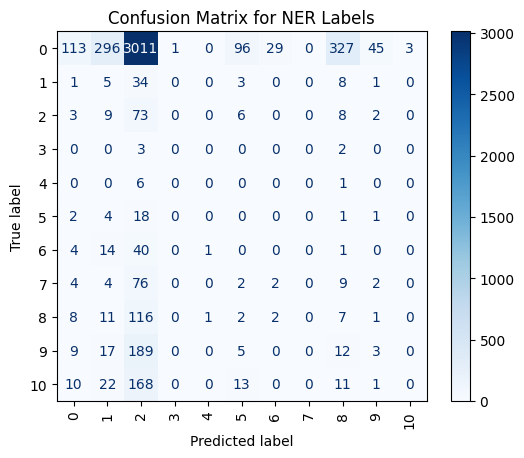

In [59]:
# Evaluate the model
trainer.evaluate()

  3%|▎         | 118/3480 [00:12<17:44,  3.16it/s]

{'eval_loss': 2.3035709857940674, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.11231809797089568}, 'eval_f1': 0.16721543572007594, 'eval_runtime': 1.4753, 'eval_samples_per_second': 130.141, 'eval_steps_per_second': 16.268, 'epoch': 1.0}


  7%|▋         | 234/3480 [00:25<16:59,  3.18it/s]

{'eval_loss': 2.2362310886383057, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.2342693174830908}, 'eval_f1': 0.3265247787161365, 'eval_runtime': 1.4723, 'eval_samples_per_second': 130.41, 'eval_steps_per_second': 16.301, 'epoch': 2.0}


 10%|█         | 350/3480 [00:38<16:45,  3.11it/s]

{'eval_loss': 2.169038772583008, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.39659766345562614}, 'eval_f1': 0.4804878944126773, 'eval_runtime': 1.501, 'eval_samples_per_second': 127.911, 'eval_steps_per_second': 15.989, 'epoch': 3.0}


 13%|█▎        | 466/3480 [00:50<15:47,  3.18it/s]

{'eval_loss': 2.102311372756958, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.5579012092641935}, 'eval_f1': 0.5916273814858479, 'eval_runtime': 1.4608, 'eval_samples_per_second': 131.434, 'eval_steps_per_second': 16.429, 'epoch': 4.0}


 14%|█▍        | 500/3480 [00:53<04:50, 10.26it/s]

{'loss': 2.2759, 'grad_norm': 8.48035717010498, 'learning_rate': 1.7126436781609195e-06, 'epoch': 4.31}


/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/peft/utils/save_and_load.py:257: UserWarning:

Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.

 17%|█▋        | 581/3480 [01:03<15:08,  3.19it/s]

{'eval_loss': 2.0364842414855957, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.6693994671039147}, 'eval_f1': 0.6527081468008329, 'eval_runtime': 1.4652, 'eval_samples_per_second': 131.042, 'eval_steps_per_second': 16.38, 'epoch': 5.0}


 20%|██        | 697/3480 [01:16<14:45,  3.14it/s]

{'eval_loss': 1.9717203378677368, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.7472842795654847}, 'eval_f1': 0.6916505439549575, 'eval_runtime': 1.4882, 'eval_samples_per_second': 129.013, 'eval_steps_per_second': 16.127, 'epoch': 6.0}


 23%|██▎       | 813/3480 [01:29<14:06,  3.15it/s]

{'eval_loss': 1.908347725868225, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.775158844025415}, 'eval_f1': 0.7027509427569139, 'eval_runtime': 1.4758, 'eval_samples_per_second': 130.102, 'eval_steps_per_second': 16.263, 'epoch': 7.0}


 27%|██▋       | 929/3480 [01:42<13:28,  3.16it/s]

{'eval_loss': 1.846950650215149, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.790735806517729}, 'eval_f1': 0.7102222190713585, 'eval_runtime': 1.4811, 'eval_samples_per_second': 129.633, 'eval_steps_per_second': 16.204, 'epoch': 8.0}


 29%|██▊       | 1000/3480 [01:49<04:03, 10.17it/s]

{'loss': 2.0152, 'grad_norm': 8.299657821655273, 'learning_rate': 1.425287356321839e-06, 'epoch': 8.62}


/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/peft/utils/save_and_load.py:257: UserWarning:

Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.

 30%|███       | 1046/3480 [01:55<13:08,  3.09it/s]

{'eval_loss': 1.7874250411987305, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.7991391678622669}, 'eval_f1': 0.7142522628648161, 'eval_runtime': 1.504, 'eval_samples_per_second': 127.662, 'eval_steps_per_second': 15.958, 'epoch': 9.0}


 33%|███▎      | 1161/3480 [02:08<13:11,  2.93it/s]

{'eval_loss': 1.7303086519241333, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8011887681902029}, 'eval_f1': 0.7151061142895027, 'eval_runtime': 1.487, 'eval_samples_per_second': 129.116, 'eval_steps_per_second': 16.139, 'epoch': 10.0}


 37%|███▋      | 1277/3480 [02:21<11:40,  3.14it/s]

{'eval_loss': 1.675837516784668, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8022135683541709}, 'eval_f1': 0.7155321659501147, 'eval_runtime': 1.4792, 'eval_samples_per_second': 129.796, 'eval_steps_per_second': 16.224, 'epoch': 11.0}


 40%|████      | 1394/3480 [02:34<09:55,  3.50it/s]

{'eval_loss': 1.6243133544921875, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8026234884197582}, 'eval_f1': 0.7157349779608533, 'eval_runtime': 1.5161, 'eval_samples_per_second': 126.637, 'eval_steps_per_second': 15.83, 'epoch': 12.0}


 43%|████▎     | 1500/3480 [02:45<03:09, 10.47it/s]

{'loss': 1.783, 'grad_norm': 6.789173603057861, 'learning_rate': 1.1379310344827587e-06, 'epoch': 12.93}


/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/peft/utils/save_and_load.py:257: UserWarning:

Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.

 43%|████▎     | 1509/3480 [02:47<12:20,  2.66it/s]

{'eval_loss': 1.5754632949829102, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.803238368518139}, 'eval_f1': 0.716039023066869, 'eval_runtime': 1.4564, 'eval_samples_per_second': 131.831, 'eval_steps_per_second': 16.479, 'epoch': 13.0}


 47%|████▋     | 1625/3480 [03:00<10:27,  2.96it/s]

{'eval_loss': 1.5301052331924438, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8036482885837262}, 'eval_f1': 0.7161602135310887, 'eval_runtime': 1.624, 'eval_samples_per_second': 118.23, 'eval_steps_per_second': 14.779, 'epoch': 14.0}


 50%|█████     | 1741/3480 [03:13<09:00,  3.22it/s]

{'eval_loss': 1.4876645803451538, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8036482885837262}, 'eval_f1': 0.7161602135310887, 'eval_runtime': 1.4385, 'eval_samples_per_second': 133.473, 'eval_steps_per_second': 16.684, 'epoch': 15.0}


 53%|█████▎    | 1858/3480 [03:25<08:21,  3.24it/s]

{'eval_loss': 1.4487380981445312, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8036482885837262}, 'eval_f1': 0.7161602135310887, 'eval_runtime': 1.4246, 'eval_samples_per_second': 134.774, 'eval_steps_per_second': 16.847, 'epoch': 16.0}


 57%|█████▋    | 1973/3480 [03:40<23:19,  1.08it/s]

{'eval_loss': 1.4128971099853516, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8036482885837262}, 'eval_f1': 0.7161602135310887, 'eval_runtime': 2.682, 'eval_samples_per_second': 71.587, 'eval_steps_per_second': 8.948, 'epoch': 17.0}


 57%|█████▋    | 2000/3480 [03:43<03:06,  7.95it/s]

{'loss': 1.5951, 'grad_norm': 4.926090717315674, 'learning_rate': 8.50574712643678e-07, 'epoch': 17.24}


/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/peft/utils/save_and_load.py:257: UserWarning:

Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.

 60%|██████    | 2089/3480 [03:57<19:11,  1.21it/s]

{'eval_loss': 1.380393624305725, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8036482885837262}, 'eval_f1': 0.7161602135310887, 'eval_runtime': 2.3843, 'eval_samples_per_second': 80.528, 'eval_steps_per_second': 10.066, 'epoch': 18.0}


 63%|██████▎   | 2205/3480 [04:14<18:40,  1.14it/s]

{'eval_loss': 1.3512107133865356, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8036482885837262}, 'eval_f1': 0.7161602135310887, 'eval_runtime': 2.5229, 'eval_samples_per_second': 76.104, 'eval_steps_per_second': 9.513, 'epoch': 19.0}


 67%|██████▋   | 2322/3480 [04:29<06:30,  2.97it/s]

{'eval_loss': 1.3251663446426392, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8036482885837262}, 'eval_f1': 0.7161602135310887, 'eval_runtime': 1.5238, 'eval_samples_per_second': 126.002, 'eval_steps_per_second': 15.75, 'epoch': 20.0}


 70%|███████   | 2436/3480 [04:41<02:03,  8.47it/s]/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


 70%|███████   | 2437/3480 [04:43<15:15,  1.14it/s]

{'eval_loss': 1.3020480871200562, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8036482885837262}, 'eval_f1': 0.7161602135310887, 'eval_runtime': 2.4758, 'eval_samples_per_second': 77.549, 'eval_steps_per_second': 9.694, 'epoch': 21.0}


 72%|███████▏  | 2500/3480 [04:52<02:34,  6.35it/s]

{'loss': 1.4603, 'grad_norm': 5.387764930725098, 'learning_rate': 5.632183908045976e-07, 'epoch': 21.55}


/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/peft/utils/save_and_load.py:257: UserWarning:

Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.

 73%|███████▎  | 2553/3480 [05:04<14:13,  1.09it/s]

{'eval_loss': 1.2818692922592163, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8036482885837262}, 'eval_f1': 0.7161602135310887, 'eval_runtime': 2.5856, 'eval_samples_per_second': 74.258, 'eval_steps_per_second': 9.282, 'epoch': 22.0}


 77%|███████▋  | 2669/3480 [05:21<10:59,  1.23it/s]

{'eval_loss': 1.2647366523742676, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8036482885837262}, 'eval_f1': 0.7161602135310887, 'eval_runtime': 2.2998, 'eval_samples_per_second': 83.484, 'eval_steps_per_second': 10.436, 'epoch': 23.0}


 80%|████████  | 2785/3480 [05:40<14:47,  1.28s/it]

{'eval_loss': 1.2501072883605957, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8036482885837262}, 'eval_f1': 0.7161602135310887, 'eval_runtime': 3.8176, 'eval_samples_per_second': 50.293, 'eval_steps_per_second': 6.287, 'epoch': 24.0}


 83%|████████▎ | 2901/3480 [06:00<13:05,  1.36s/it]

{'eval_loss': 1.238122820854187, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8036482885837262}, 'eval_f1': 0.7161602135310887, 'eval_runtime': 4.0381, 'eval_samples_per_second': 47.547, 'eval_steps_per_second': 5.943, 'epoch': 25.0}


 86%|████████▌ | 3000/3480 [06:13<00:57,  8.38it/s]

{'loss': 1.3719, 'grad_norm': 4.988919258117676, 'learning_rate': 2.758620689655172e-07, 'epoch': 25.86}


/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/peft/utils/save_and_load.py:257: UserWarning:

Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.

 87%|████████▋ | 3017/3480 [06:18<06:43,  1.15it/s]

{'eval_loss': 1.2284775972366333, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8036482885837262}, 'eval_f1': 0.7161602135310887, 'eval_runtime': 2.4957, 'eval_samples_per_second': 76.931, 'eval_steps_per_second': 9.616, 'epoch': 26.0}


 90%|█████████ | 3133/3480 [06:38<08:12,  1.42s/it]

{'eval_loss': 1.2211110591888428, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8036482885837262}, 'eval_f1': 0.7161602135310887, 'eval_runtime': 4.2277, 'eval_samples_per_second': 45.415, 'eval_steps_per_second': 5.677, 'epoch': 27.0}


 93%|█████████▎| 3249/3480 [06:56<03:50,  1.00it/s]

{'eval_loss': 1.215927243232727, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8036482885837262}, 'eval_f1': 0.7161602135310887, 'eval_runtime': 3.8468, 'eval_samples_per_second': 49.911, 'eval_steps_per_second': 6.239, 'epoch': 28.0}


 97%|█████████▋| 3365/3480 [07:12<01:41,  1.14it/s]

{'eval_loss': 1.2128397226333618, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8036482885837262}, 'eval_f1': 0.7161602135310887, 'eval_runtime': 2.5266, 'eval_samples_per_second': 75.99, 'eval_steps_per_second': 9.499, 'epoch': 29.0}


100%|██████████| 3480/3480 [07:28<00:00,  8.73it/s]/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/peft/utils/save_and_load.py:257: UserWarning:

Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.


100%|██████████| 3480/3480 [07:31<00:00,  7.71it/s]


{'eval_loss': 1.2118271589279175, 'eval_model_preparation_time': 0.0042, 'eval_accuracy': {'accuracy': 0.8036482885837262}, 'eval_f1': 0.7161602135310887, 'eval_runtime': 2.4579, 'eval_samples_per_second': 78.115, 'eval_steps_per_second': 9.764, 'epoch': 30.0}
{'train_runtime': 451.4203, 'train_samples_per_second': 61.606, 'train_steps_per_second': 7.709, 'train_loss': 1.6936368218783675, 'epoch': 30.0}


/home/julita/anaconda3/envs/myenv/lib/python3.10/site-packages/peft/utils/save_and_load.py:257: UserWarning:

Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.



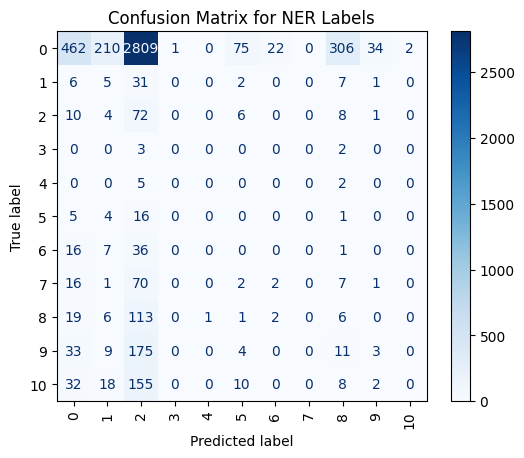

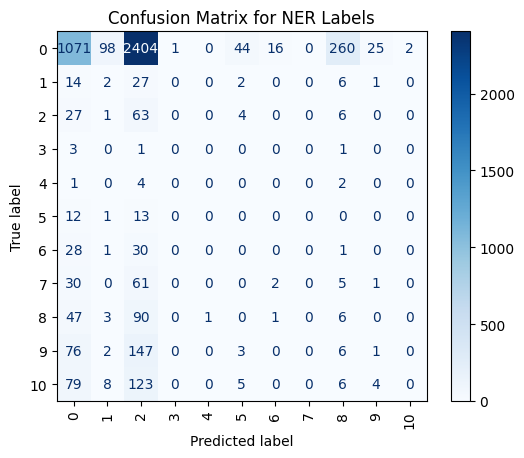

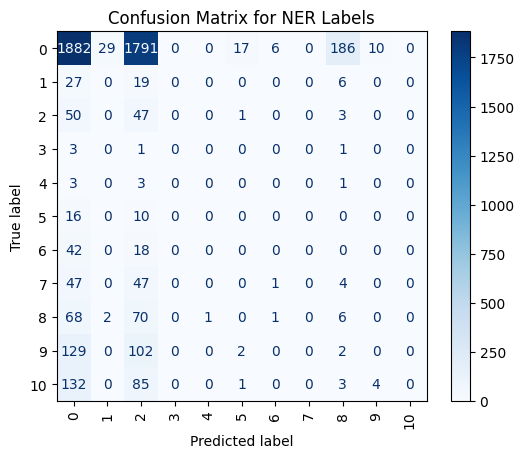

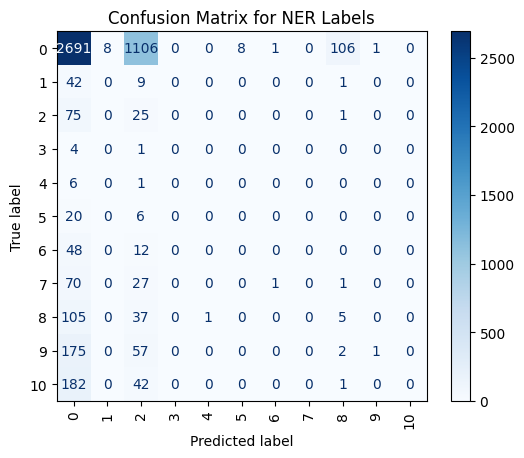

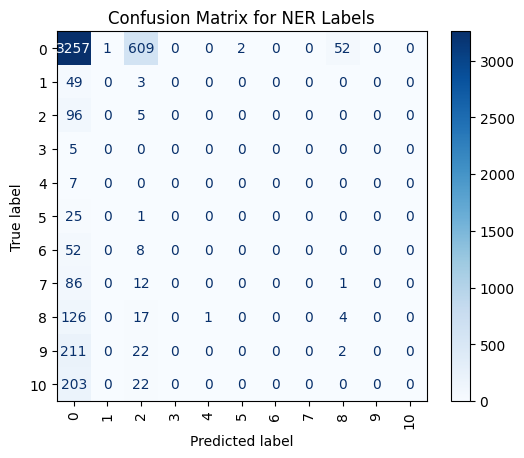

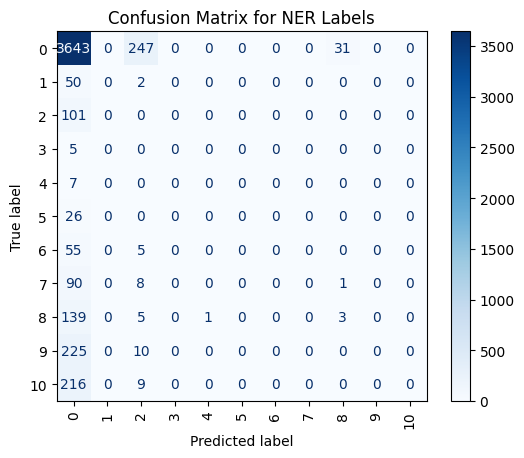

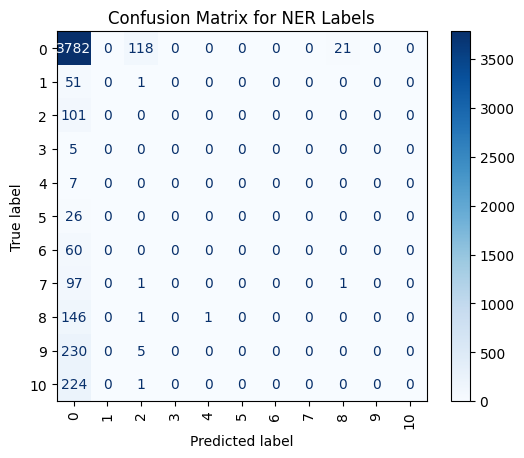

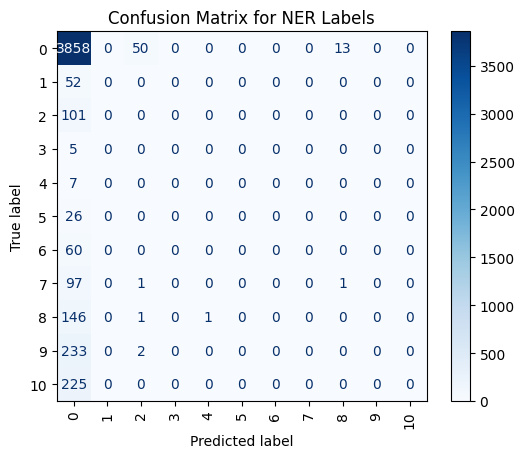

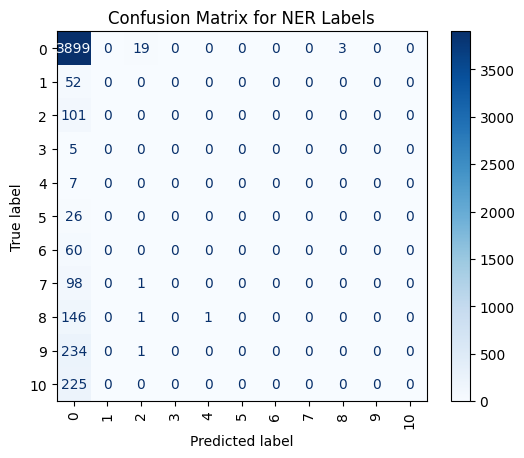

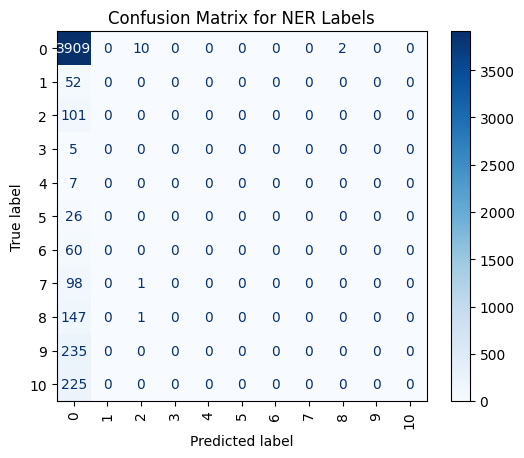

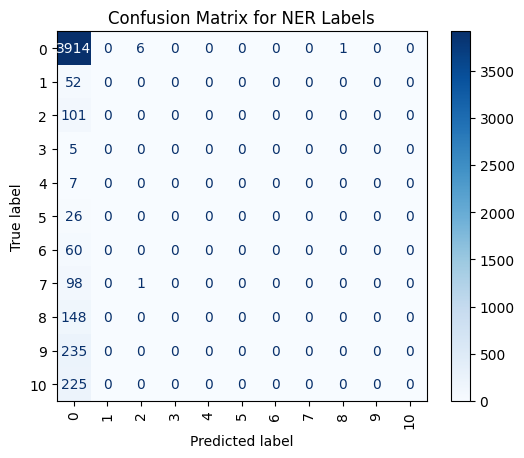

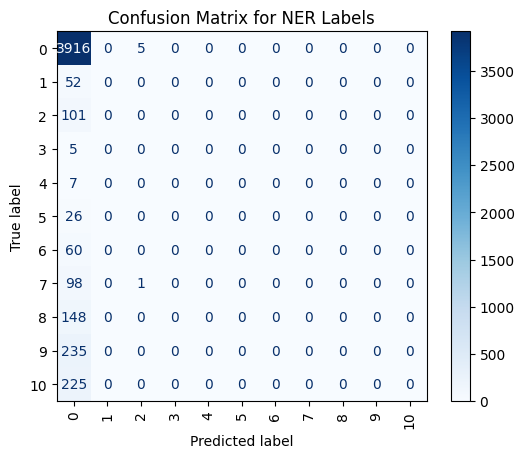

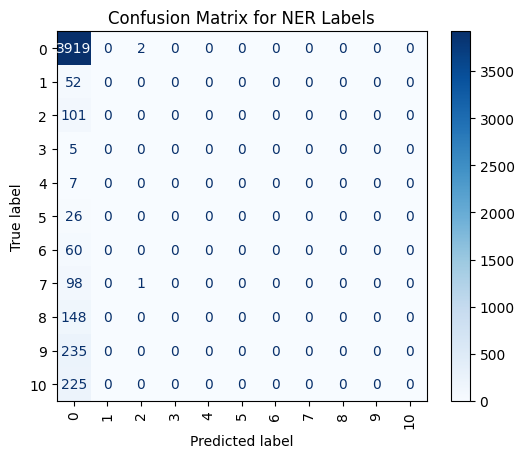

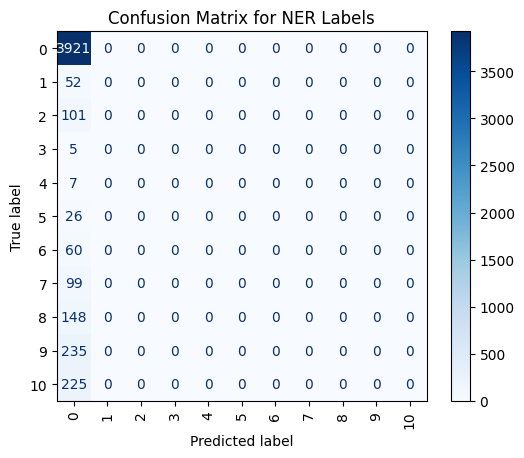

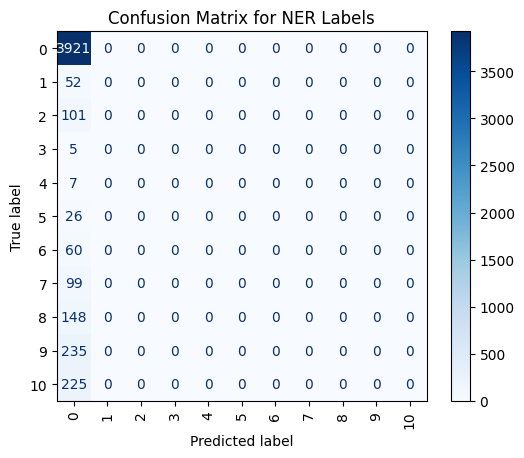

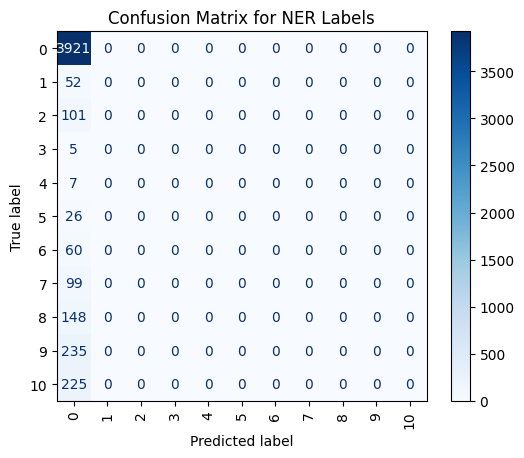

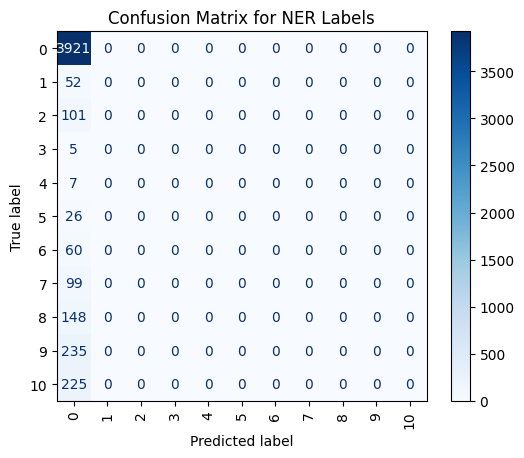

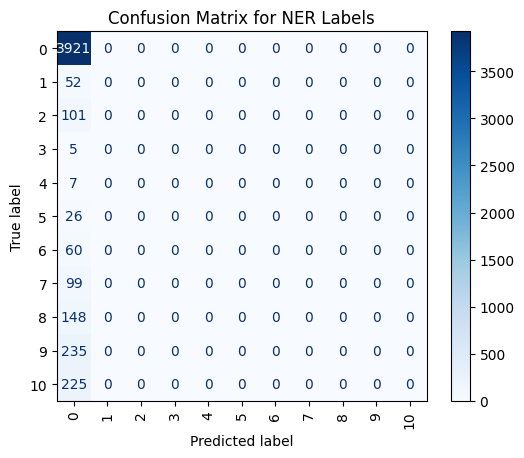

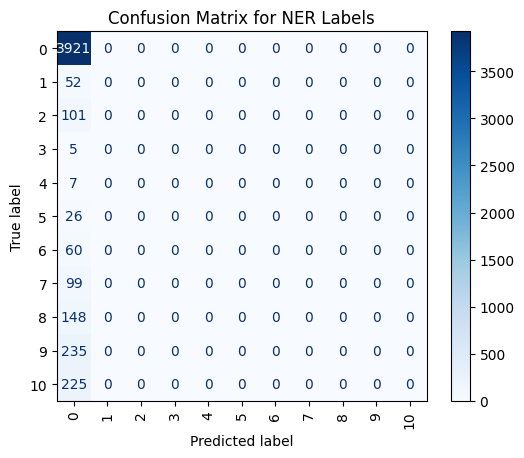

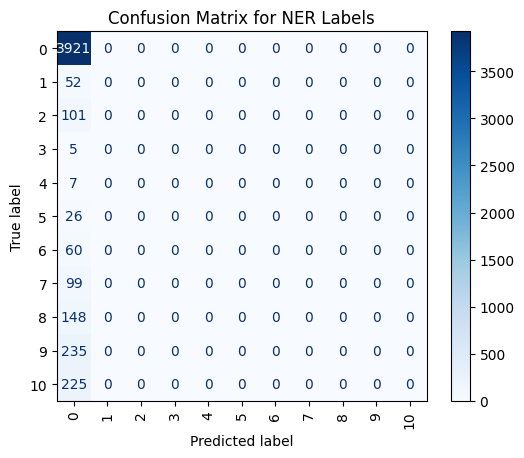

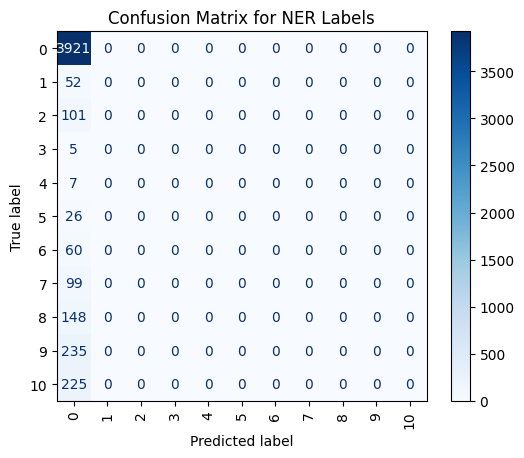

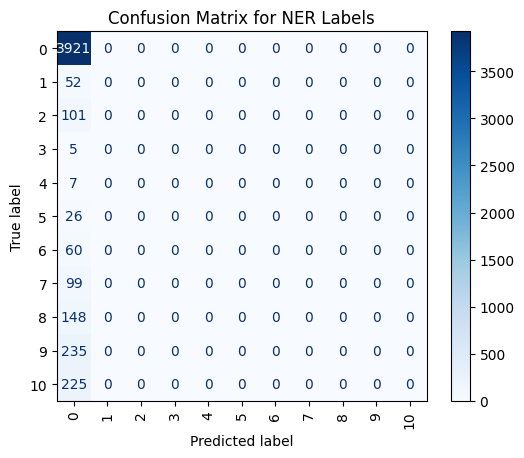

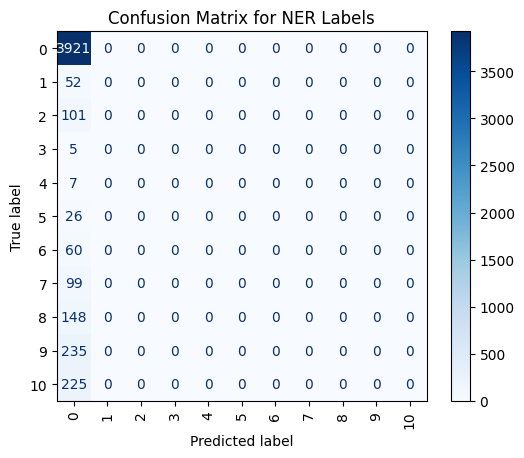

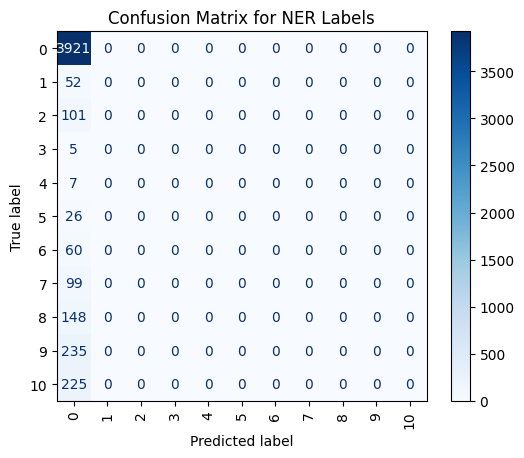

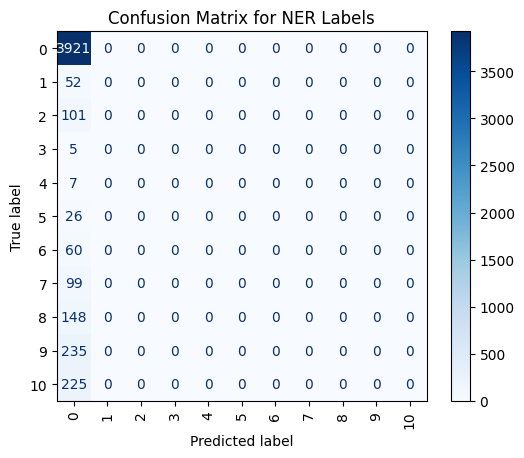

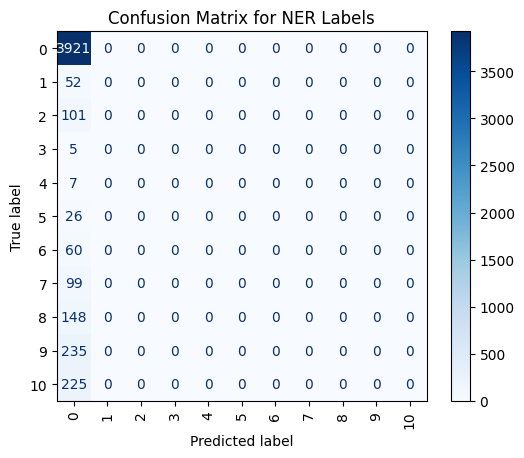

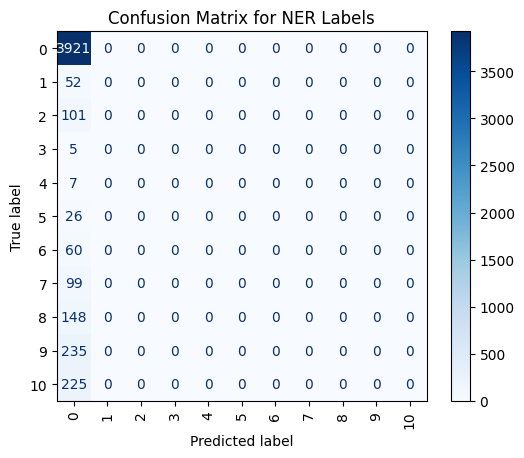

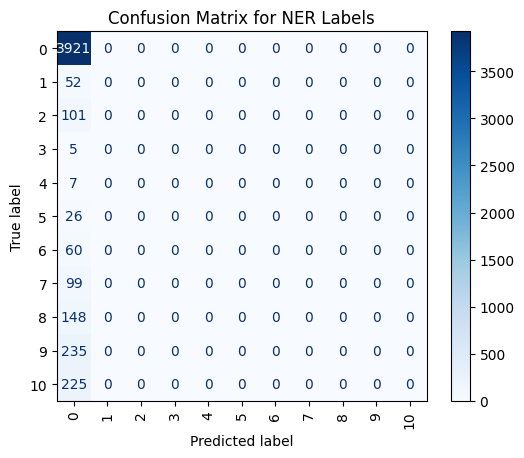

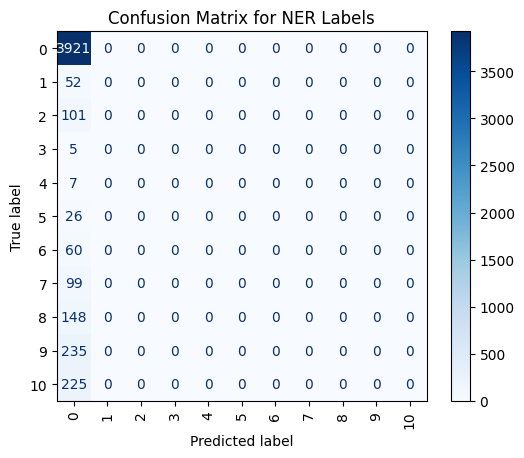

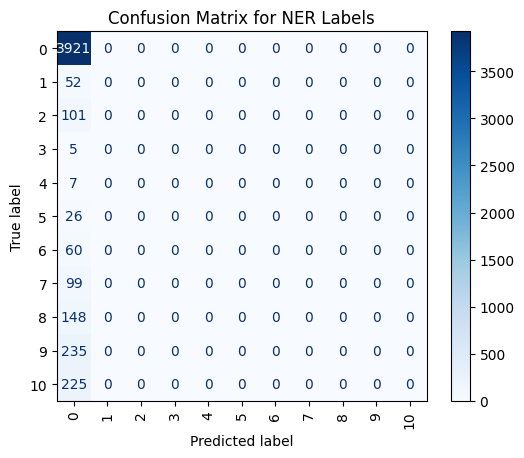

In [60]:
trainer.train()
trainer.save_model("./saved_model_bert_lora_for_token")

100%|██████████| 24/24 [00:03<00:00,  6.80it/s]


{'eval_loss': 1.2118271589279175,
 'eval_model_preparation_time': 0.0042,
 'eval_accuracy': {'accuracy': 0.8036482885837262},
 'eval_f1': 0.7161602135310887,
 'eval_runtime': 3.5916,
 'eval_samples_per_second': 53.458,
 'eval_steps_per_second': 6.682,
 'epoch': 30.0}

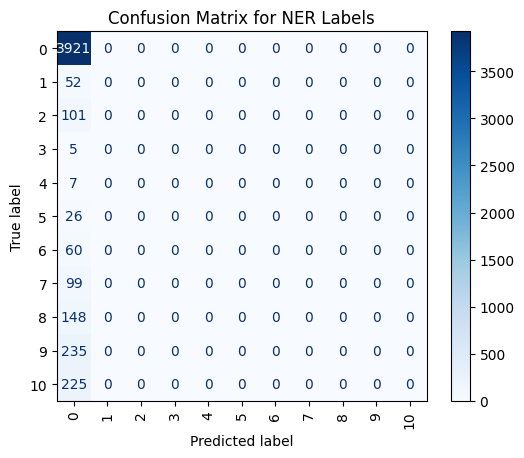

In [61]:
trainer.evaluate()

# Wizualizacje na wytrenowanym modelu

In [62]:
from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer
import torch

# Ścieżka do zapisanych wag modelu
model_path = "./saved_model_bert_lora_for_token"

# Wczytanie konfiguracji z odpowiednią liczbą etykiet
config = AutoConfig.from_pretrained(model_path)
config.num_labels = num_labels# Upewnij się, że jest to liczba etykiet, której używałeś podczas trenowania

# Wczytanie modelu i tokenizera
model = AutoModelForTokenClassification.from_pretrained(model_path, config=config, ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Przekazanie modelu na GPU, jeśli jest dostępne
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized because the shapes did not match:
- bert.embeddings.word_embeddings.weight: found shape torch.Size([28996, 768]) in the checkpoint and torch.Size([30522, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): lora.Linear(
                (base_layer): Linear(in_features=768, out_features=768, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=7

In [63]:
import torch
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
import numpy as np



test_dataset = tokenized_datasets["validation"].select(range(15))
print(test_dataset[0])


def get_embeddings(dataset, model, tokenizer):
    model.eval()
    embeddings = []
    labels = []
    tokens = []
    
    with torch.no_grad():
        for example in dataset:
            inputs = tokenizer(
                example["tokens"],is_split_into_words=True,return_tensors="pt", truncation=True, padding='max_length', max_length=128
            ).to(device)
            outputs = model(**inputs, output_hidden_states=True)
       
            token_embeddings = outputs.hidden_states[-1].squeeze(0) 
            embeddings.append(token_embeddings.cpu().numpy())
            labels.extend(example["ner_tags"])
            tokens.extend(example["tokens"])


    flat_embeddings = np.vstack([embedding[:len(label)] for embedding, label in zip(embeddings, dataset["ner_tags"])])
    flat_labels = [label for sublist in dataset["ner_tags"] for label in sublist]
    flat_tokens = [token for sublist in dataset["tokens"] for token in sublist]
    
    return flat_embeddings, flat_labels, flat_tokens

embeddings, labels, tokens = get_embeddings(test_dataset, model, tokenizer)


reducer = TSNE(n_components=2, random_state=42)
reduced_embeddings = reducer.fit_transform(embeddings)


df = pd.DataFrame({
    "x": reduced_embeddings[:, 0],
    "y": reduced_embeddings[:, 1],
    "label": labels,
    "token": tokens
})

fig = px.scatter(
    df, x="x", y="y", color="label", hover_data=["token"],
    title="2D Vector Space of Test Examples",
    labels={"color": "NER Label"}
)
fig.show()


{'id': '3247', 'tokens': ['This', 'result', 'was', 'confirmed', 'using', 'clones', 'of', 'EL4', 'cells', 'stably', 'expressing', 'an', 'inducible', 'form', 'of', 'SKAT-2', ',', 'thus', 'SKAT-2', 'is', 'a', 'novel', 'Th2-specific', 'gene', 'that', 'may', 'play', 'a', 'role', 'in', 'selective', 'regulation', 'of', 'cytokine', 'genes', 'in', 'T', 'cells', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 7, 8, 0], 'input_ids': [101, 1188, 1871, 1108, 3659, 1606, 22121, 1116, 1104, 142, 2162, 1527, 3652, 19428, 1193, 14819, 1126, 1107, 7641, 16240, 1532, 1104, 17447, 13821, 118, 123, 117, 2456, 17447, 13821, 118, 123, 1110, 170, 2281, 157, 1324, 1477, 118, 2747, 5565, 1115, 1336, 1505, 170, 1648, 1107, 14930, 8585, 1104, 172, 25669, 21420, 1673, 9077, 1107, 157, 3652, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [64]:
# Dodajmy identyfikatory przykładów do DataFrame
example_ids = []
for idx, example in enumerate(test_dataset):
    example_ids.extend([idx] * len(example["tokens"]))

# Aktualizujemy DataFrame o identyfikatory przykładów
df["example_id"] = example_ids

# Tworzymy nowy wykres
fig2 = px.scatter(
    df, x="x", y="y", color="example_id", hover_data=["token"],
    title="2D Vector Space of Test Examples (Grouped by Example)",
    labels={"color": "Example ID"}
)
fig2.show()


# Wizauliacja poprawnych przykładów

In [65]:
import torch
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
import numpy as np
from datasets import load_dataset

test_dataset = dataset["validation"].select(range(100))  

# Funkcja do uzyskania embeddingów i przewidywań
def get_predictions_and_embeddings(dataset, model, tokenizer):
    model.eval()
    embeddings = []
    true_labels = []
    pred_labels = []
    tokens = []
    correct_examples = []

    with torch.no_grad():
        for example in dataset:
            inputs = tokenizer(
                example["tokens"], is_split_into_words=True, return_tensors="pt",
                truncation=True, padding='max_length', max_length=128
            ).to(device)
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1).squeeze().cpu().numpy()

            # Pobieramy embeddingi
            token_embeddings = outputs.hidden_states[-1].squeeze(0).cpu().numpy()
            true_label = example["ner_tags"]
            tokens.extend(example["tokens"])

            # Dopasowujemy długość predykcji do prawdziwych etykiet
            predictions = predictions[:len(true_label)]

            if list(predictions) == true_label:
                embeddings.append(token_embeddings[:len(true_label)])
                true_labels.extend(true_label)
                pred_labels.extend(predictions)
                correct_examples.extend(example["tokens"])

    # Spłaszczamy embeddingi
    flat_embeddings = np.vstack([emb for emb in embeddings])
    flat_labels = true_labels
    flat_tokens = [token for sublist in correct_examples for token in sublist]

    return flat_embeddings, flat_labels, flat_tokens

# Pobieramy embeddingi i poprawnie sklasyfikowane przykłady
embeddings, labels, tokens = get_predictions_and_embeddings(test_dataset, model, tokenizer)

# Sprawdzamy najmniejszą długość
min_length = min(len(reduced_embeddings), len(labels), len(tokens))

# Przycinamy listy do tej długości
reduced_embeddings = reduced_embeddings[:min_length]
labels = labels[:min_length]
tokens = tokens[:min_length]

# Tworzymy DataFrame do wizualizacji
df = pd.DataFrame({
    "x": reduced_embeddings[:, 0],
    "y": reduced_embeddings[:, 1],
    "label": labels,
    "token": tokens
})

# Wizualizacja za pomocą Plotly
fig = px.scatter(
    df, x="x", y="y", color="label", hover_data=["token"],
    title="2D Vector Space of Correctly Classified Examples",
    labels={"color": "NER Label"}
)
fig.show()


In [66]:
import torch
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
import numpy as np



test_dataset = tokenized_datasets["train"]
print(test_dataset[0])

def get_embeddings(dataset, model, tokenizer):
    model.eval()
    embeddings = []
    labels = []
    tokens = []
    
    with torch.no_grad():
        for example in dataset:
            inputs = tokenizer(
                example["tokens"], is_split_into_words=True, return_tensors="pt",
                truncation=True, padding='max_length', max_length=128
            ).to(device)
            
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1).squeeze().cpu()

            token_embeddings = outputs.hidden_states[-1].squeeze(0)
            true_label = example["ner_tags"]
            predictions = predictions[:len(true_label)]

            # Only append correctly classified examples
            if list(predictions) == true_label:
                embeddings.append(token_embeddings[:len(true_label)].cpu().numpy())
                labels.extend(true_label)
                tokens.extend(example["tokens"][:len(true_label)])

    # Flatten the embeddings and ensure lengths match
    flat_embeddings = np.vstack(embeddings)
    flat_labels = labels
    flat_tokens = tokens

    print(f"Lengths - embeddings: {len(flat_embeddings)}, labels: {len(flat_labels)}, tokens: {len(flat_tokens)}")

    return flat_embeddings, flat_labels, flat_tokens



embeddings, labels, tokens = get_embeddings(test_dataset, model, tokenizer)


reducer = TSNE(n_components=2, random_state=42)
reduced_embeddings = reducer.fit_transform(embeddings)


df = pd.DataFrame({
    "x": reduced_embeddings[:, 0],
    "y": reduced_embeddings[:, 1],
    "label": labels,
    "token": tokens
})

fig = px.scatter(
    df, x="x", y="y", color="label", hover_data=["token"],
    title="2D Vector Space of Test Examples",
    labels={"color": "NER Label"}
)
fig.show()


{'id': '16921', 'tokens': ['We', 'have', 'carried', 'out', 'experiments', 'to', 'define', 'the', 'nature', 'of', 'the', 'higher', 'affinity', 'CVZ', 'binding', 'site', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 10, 10, 10, 10, 0], 'input_ids': [101, 1284, 1138, 2446, 1149, 7857, 1106, 9410, 1103, 2731, 1104, 1103, 2299, 18859, 140, 2559, 5301, 7861, 1751, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Poprawe z wyłączeniem 0

In [67]:
def get_embeddings(dataset, model, tokenizer):
    model.eval()
    embeddings = []
    labels = []
    tokens = []
    accuracy_threshold = 0.4 

    with torch.no_grad():
        for example in dataset:
            inputs = tokenizer(
                example["tokens"], is_split_into_words=True, return_tensors="pt",
                truncation=True, padding='max_length', max_length=128
            ).to(device)
            
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1).squeeze().cpu()

            # Pobieramy embeddingi i prawdziwe etykiety
            token_embeddings = outputs.hidden_states[-1].squeeze(0)
            true_labels = example["ner_tags"]
            tokens_list = example["tokens"]

        
            predictions = predictions[:len(true_labels)]

            # Filtrowanie etykiet `0`
            non_zero_indices = [i for i, label in enumerate(true_labels) if label != 0]
            filtered_predictions = [predictions[i] for i in non_zero_indices]
            filtered_true_labels = [true_labels[i] for i in non_zero_indices]
            filtered_tokens = [tokens_list[i] for i in non_zero_indices]
            filtered_embeddings = token_embeddings[non_zero_indices].cpu().numpy()


            if len(filtered_true_labels) > 0: 
                correct_predictions = sum(
                    [1 for pred, true in zip(filtered_predictions, filtered_true_labels) if pred == true]
                )
                accuracy = correct_predictions / len(filtered_true_labels)

    
                if accuracy >= accuracy_threshold:
                    embeddings.append(filtered_embeddings)
                    labels.extend(filtered_true_labels)
                    tokens.extend(filtered_tokens)

    if(len(embeddings) > 0):
        print('S')
        # Spłaszczamy listy
        flat_embeddings = np.vstack(embeddings)
        flat_labels = labels
        flat_tokens = tokens

        print(f"Lengths - embeddings: {len(flat_embeddings)}, labels: {len(flat_labels)}, tokens: {len(flat_tokens)}")

        return flat_embeddings, flat_labels, flat_tokens
    else: 
        print('Empty!')
        return [], [], []

In [69]:
embeddings, labels, tokens = get_embeddings(test_dataset, model, tokenizer)
if(len(embeddings) > 0):
    reducer = TSNE(n_components=2, random_state=42)
    reduced_embeddings = reducer.fit_transform(embeddings)


    df = pd.DataFrame({
        "x": reduced_embeddings[:, 0],
        "y": reduced_embeddings[:, 1],
        "label": labels,
        "token": tokens
    })

    fig = px.scatter(
        df, x="x", y="y", color="label", hover_data=["token"],
        title="2D Vector Space of Test Examples",
        labels={"color": "NER Label"}
    )
    fig.show()

Empty!
